<a href="https://colab.research.google.com/github/RachitBansal/AppliancePower_TimeSeries/blob/master/Ensemble_Ukdale_5mins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
####code to  upload the data and resample the data (day wise)
from sklearn.externals import joblib
from keras.layers import Dense ,LSTM
from keras.models import Sequential 
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
import tensorflow as tf

# import r2
# import mane

import keras.backend as K

import os

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import keras.backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [0]:
from keras.models import load_model
import xgboost

In [0]:
class Ensemble_pipeline():
  def __init__(self, equipment, n_members):
    self.eq = equipment
    self.n_members = n_members

  def load_arima_res(self):
    return np.load('./drive/My Drive/UkDale/ARIMA/arima_ukdale_preds_1000_eq'+str(self.eq)+'.npy')

  def fit_cnn_lstm(self, x_train, y_train):
    n_timesteps, n_features = x_train.shape[1], x_train.shape[2]
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(1))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    # model.summary()
    model.compile(loss='mse', optimizer='adam',metrics = ["accuracy"])

    model.fit(x_train, y_train, epochs=10, batch_size=128, verbose = 1)
    
    return model

  def load_data(self):
    self.train_x = np.load(file='./drive/My Drive/UkDale/ukdale_'+str(self.eq)+'_x.npy')
    self.train_y = np.load(file='./drive/My Drive/UkDale/ukdale_'+str(self.eq)+'_y.npy')
    test_x = np.load(file='./drive/My Drive/UkDale/ukdale_'+str(self.eq)+'_tx.npy')
    test_y = np.load(file='./drive/My Drive/UkDale/ukdale_'+str(self.eq)+'_ty.npy')
    val_split = int(0.2*test_x.shape[0])
    self.val_x = test_x[-val_split:]
    self.val_y = test_y[-val_split:]
    self.test_x = test_x[:-val_split]
    self.test_y = test_y[:-val_split]
    print(self.val_x.shape, self.val_y.shape, self.test_x.shape, self.test_y.shape)
  
  def load_all_models(self):
    all_models = list()
    for i in range(self.n_members):
        # define filename for this ensemble
        filename = './drive/My Drive/ukdale'+str(self.eq-1)+'_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>>> loaded %s' % filename)
    return all_models

  def stacked_dataset(self, inputX):
    stackX = None
    for model in self.members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))

    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

  def fit_stacked_model(self, inputX, inputy, n_est=45, alpha = 10):
      # create dataset using ensemble
      stackedX = self.stacked_dataset(inputX)
      # fit standalone model
      self.ensemble = xgboost.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = alpha, n_estimators = n_est)
      self.ensemble.fit(stackedX, inputy)

  def stacked_prediction(self, inputX):
      # create dataset using ensemble
      stackedX = self.stacked_dataset(inputX)
      # make a prediction
      yhat = self.ensemble.predict(stackedX)
      return yhat

  def make_cnnlstm_comparison_graph(self, n_test, idx=0):
    preds = []
    lstm_preds = []
    for i in range(n_test):
      lstm_preds.append(self.members[0].predict(self.test_x[i].reshape(1,-1,1))[0][0][0])
    e_preds = self.stacked_prediction(self.test_x[idx:idx+n_test])
    a_preds = self.load_arima_res()
    preds.append(lstm_preds)
    preds.append(e_preds)
    preds.append(a_preds[:n_test])
    print(len(preds))
    # np.save(file = './drive/My Drive/UkDale/preds_'+str(self.eq)+'.npy', arr = np.array(preds))

    plt.plot(self.test_y[idx:idx+n_test].reshape(-1), c = 'orange', label='actual')
    list_colrs = ['red', 'blue', 'red']
    labels = ['CNN-LSTM', 'XG-Boost ensemble', 'ARIMA']
    for j in range(3):
      plt.plot(preds[j], c = list_colrs[j], label=labels[j])
    plt.ylabel('Value')
    plt.xlabel('Index of Time Series Data')
    plt.legend()
    plt.show()

  def pipeline(self, n_test=100, idx=0, train=False, load=True):
    self.load_data()
    if(train):
        for i in range(self.n_members):
          model = self.fit_cnn_lstm(self.train_x, self.train_y)
          filename = './drive/My Drive/ukdale' + str(self.eq-1) + '_model_' + str(i + 1) + '.h5'
          model.save(filename)
          print('>>> Saved %s' % filename)
          
    if(load):
      self.members = self.load_all_models()
      print('Loaded %d models' % len(self.members))

    # for model in self.members:
    #   _, acc = model.evaluate(self.test_x, self.test_y, verbose=0)
    #   print('Model Accuracy: %.3f' % acc)

    self.fit_stacked_model(inputX = self.val_x, inputy = self.val_y)

    self.make_cnnlstm_comparison_graph(n_test, idx)

In [0]:
d={}

(37501, 128, 1) (37501, 1, 1) (187509, 128, 1) (187509, 1, 1)
Epoch 1/10
281327/281327 [==============================] - 41s 147us/step - loss: 1490.0055 - acc: 0.0306
Epoch 2/10
281327/281327 [==============================] - 33s 118us/step - loss: 1334.7846 - acc: 0.0192
Epoch 3/10
281327/281327 [==============================] - 33s 117us/step - loss: 1294.9751 - acc: 0.0167
Epoch 4/10
281327/281327 [==============================] - 33s 119us/step - loss: 1263.1979 - acc: 0.0156
Epoch 5/10
281327/281327 [==============================] - 33s 119us/step - loss: 1241.6981 - acc: 0.0178
Epoch 6/10
281327/281327 [==============================] - 34s 120us/step - loss: 1219.1851 - acc: 0.0162
Epoch 7/10
281327/281327 [==============================] - 34s 120us/step - loss: 1197.7515 - acc: 0.0199
Epoch 8/10
281327/281327 [==============================] - 33s 119us/step - loss: 1175.2722 - acc: 0.0188
Epoch 9/10
281327/281327 [==============================] - 33s 119us/step - loss:

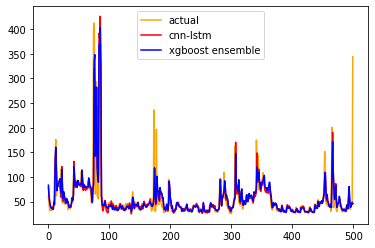

(37501, 128, 1) (37501, 1, 1) (187509, 128, 1) (187509, 1, 1)
Epoch 1/10
281327/281327 [==============================] - 43s 155us/step - loss: 1.8065 - acc: 0.1686
Epoch 2/10
281327/281327 [==============================] - 33s 119us/step - loss: 1.3020 - acc: 0.1716
Epoch 3/10
281327/281327 [==============================] - 34s 119us/step - loss: 1.2036 - acc: 0.1723
Epoch 4/10
281327/281327 [==============================] - 33s 118us/step - loss: 1.1448 - acc: 0.1727
Epoch 5/10
281327/281327 [==============================] - 34s 120us/step - loss: 1.0798 - acc: 0.1732
Epoch 6/10
281327/281327 [==============================] - 34s 119us/step - loss: 1.0210 - acc: 0.1732
Epoch 7/10
281327/281327 [==============================] - 33s 119us/step - loss: 0.9535 - acc: 0.1734
Epoch 8/10
281327/281327 [==============================] - 34s 120us/step - loss: 0.8789 - acc: 0.1736
Epoch 9/10
281327/281327 [==============================] - 33s 119us/step - loss: 0.8095 - acc: 0.1736
Ep

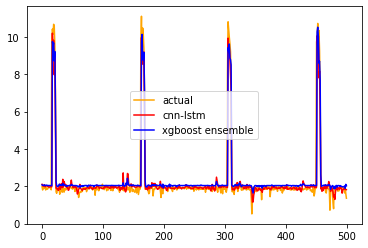

(37501, 128, 1) (37501, 1, 1) (187509, 128, 1) (187509, 1, 1)
Epoch 1/10
281327/281327 [==============================] - 45s 161us/step - loss: 1.1541 - acc: 0.7192
Epoch 2/10
281327/281327 [==============================] - 34s 122us/step - loss: 1.0050 - acc: 0.7245
Epoch 3/10
281327/281327 [==============================] - 34s 120us/step - loss: 0.9677 - acc: 0.7264
Epoch 4/10
281327/281327 [==============================] - 34s 120us/step - loss: 0.9252 - acc: 0.7289
Epoch 5/10
281327/281327 [==============================] - 34s 119us/step - loss: 0.8913 - acc: 0.7315
Epoch 6/10
281327/281327 [==============================] - 34s 120us/step - loss: 0.8484 - acc: 0.7338
Epoch 7/10
281327/281327 [==============================] - 34s 120us/step - loss: 0.8027 - acc: 0.7369
Epoch 8/10
281327/281327 [==============================] - 34s 120us/step - loss: 0.7550 - acc: 0.7400
Epoch 9/10
281327/281327 [==============================] - 34s 120us/step - loss: 0.7069 - acc: 0.7427
Ep

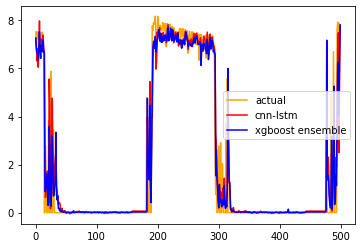

(37501, 128, 1) (37501, 1, 1) (187509, 128, 1) (187509, 1, 1)
Epoch 1/10
281328/281328 [==============================] - 47s 165us/step - loss: 206.9377 - acc: 0.3197
Epoch 2/10
281328/281328 [==============================] - 34s 121us/step - loss: 151.4256 - acc: 0.5982
Epoch 3/10
281328/281328 [==============================] - 34s 121us/step - loss: 137.9062 - acc: 0.7690
Epoch 4/10
281328/281328 [==============================] - 34s 120us/step - loss: 127.8819 - acc: 0.8270
Epoch 5/10
281328/281328 [==============================] - 34s 121us/step - loss: 118.5509 - acc: 0.8743
Epoch 6/10
281328/281328 [==============================] - 34s 121us/step - loss: 110.2967 - acc: 0.8907
Epoch 7/10
281328/281328 [==============================] - 34s 123us/step - loss: 103.7373 - acc: 0.9047
Epoch 8/10
281328/281328 [==============================] - 34s 121us/step - loss: 97.6473 - acc: 0.8985
Epoch 9/10
281328/281328 [==============================] - 34s 123us/step - loss: 95.4842 

In [0]:
# d={}
for i in range(15):
  d["obj{0}".format(i)] = Ensemble_pipeline(i+1, 3)
  if(i != 3 and i != 5):
    d["obj{0}".format(i)].pipeline(n_test = 500, train = False)
  elif(i == 5):
    d["obj{0}".format(i)].pipeline(n_test = 500, train = False, load = True)